# 🔍 Exploration des données - Détection de Fraude

**Objectif** : Comprendre la structure des données et identifier les patterns de fraude

Petite note pour moi : Ce projet me rappelle un peu le travail que j'ai fait chez Groupama sur la prédiction de satisfaction client. Même logique de déséquilibre de classes et d'importance des coûts métier.

**Dataset** : Credit Card Fraud Detection
- Transactions par carte bancaire
- Features anonymisées (PCA)
- Très déséquilibré (comme d'hab avec la fraude...)



In [1]:
# Imports classiques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Config pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports OK")


✅ Imports OK


## 1. Chargement des données

Bon, voyons ce qu'on a dans ce dataset...


In [2]:
# Charger les données
data_path = Path('../data/raw/creditcard.csv')
df = pd.read_csv(data_path)

print(f"📊 Shape: {df.shape}")
print(f"💾 Mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()


📊 Shape: (10000, 31)
💾 Mémoire: 2.37 MB


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Time,Amount,Class
0,0.496714,-0.678495,0.348286,-1.980572,-0.471858,0.098206,0.078838,0.320152,0.664001,0.960895,...,-0.538522,-1.252631,-1.453030,0.276511,0.554532,-0.141042,-0.746091,167256,165.778372,0.0
1,-0.138264,-0.305499,0.283324,-1.054986,1.012702,-0.064108,0.562897,1.115462,-0.296116,-0.369965,...,2.292061,-0.766660,0.109270,1.043696,1.753721,-0.135331,0.757040,145438,47.024205,0.0
2,0.647689,-0.597381,-0.936520,-0.587028,-0.198187,0.951791,0.341102,-1.505238,-0.066586,-0.579581,...,-1.504112,0.086829,0.485767,0.003883,-0.451468,0.075878,-0.427880,38252,28.813501,0.0
3,1.523030,0.110418,0.579584,0.149669,0.090569,1.532831,-1.277914,1.739606,-0.175382,0.933312,...,1.375205,-0.074921,0.528361,-1.038205,1.320591,0.192559,2.228718,60801,5.668574,0.0
4,-0.234153,1.197179,-1.490083,1.024162,0.717391,0.686847,-0.186220,0.330087,0.514054,-2.731540,...,0.325901,0.463245,0.882367,1.176187,-1.986991,2.256713,-0.113275,65191,60.788421,0.0


In [3]:
# Infos générales
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      10000 non-null  float64
 1   V2      10000 non-null  float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

## 2. Analyse du déséquilibre

Le gros problème avec la détection de fraude c'est toujours le déséquilibre...
Voyons combien de fraudes on a vraiment.


Transactions normales: 9,950
Fraudes: 50
Taux de fraude: 0.500%

💡 Ratio: 1 fraude pour 199 transactions normales


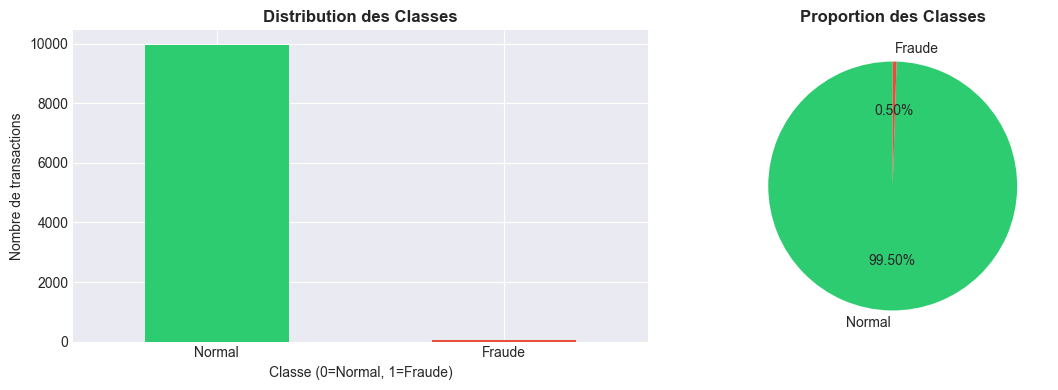

In [4]:
# Distribution des classes
class_counts = df['Class'].value_counts()
fraud_rate = (class_counts[1] / len(df)) * 100

print(f"Transactions normales: {class_counts[0]:,}")
print(f"Fraudes: {class_counts[1]:,}")
print(f"Taux de fraude: {fraud_rate:.3f}%")
print(f"\n💡 Ratio: 1 fraude pour {class_counts[0] // class_counts[1]} transactions normales")

# Viz rapide
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Barplot
class_counts.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Distribution des Classes', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Classe (0=Normal, 1=Fraude)')
ax[0].set_ylabel('Nombre de transactions')
ax[0].set_xticklabels(['Normal', 'Fraude'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
ax[1].pie(class_counts, labels=['Normal', 'Fraude'], autopct='%1.2f%%', 
          colors=colors, startangle=90)
ax[1].set_title('Proportion des Classes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Note: Va falloir gérer ce déséquilibre avec SMOTE ou autre...


## 3. Analyse des montants

Les montants des transactions peuvent être un bon indicateur. Les fraudes sont-elles plutôt sur des petits ou gros montants ?


=== Statistiques des montants ===

Toutes transactions:
count    10000.000000
mean       141.262646
std        756.666443
min          0.004766
25%          5.172079
50%         19.987942
75%         76.676830
max      32088.087139
Name: Amount, dtype: float64


Transactions normales:
count     9950.000000
mean       141.211772
std        758.320211
min          0.004766
25%          5.145043
50%         19.908300
75%         76.580557
max      32088.087139
Name: Amount, dtype: float64


Fraudes:
count      50.000000
mean      151.386464
std       274.622438
min         0.451899
25%        18.522506
50%        39.079667
75%       111.836055
max      1387.119951
Name: Amount, dtype: float64


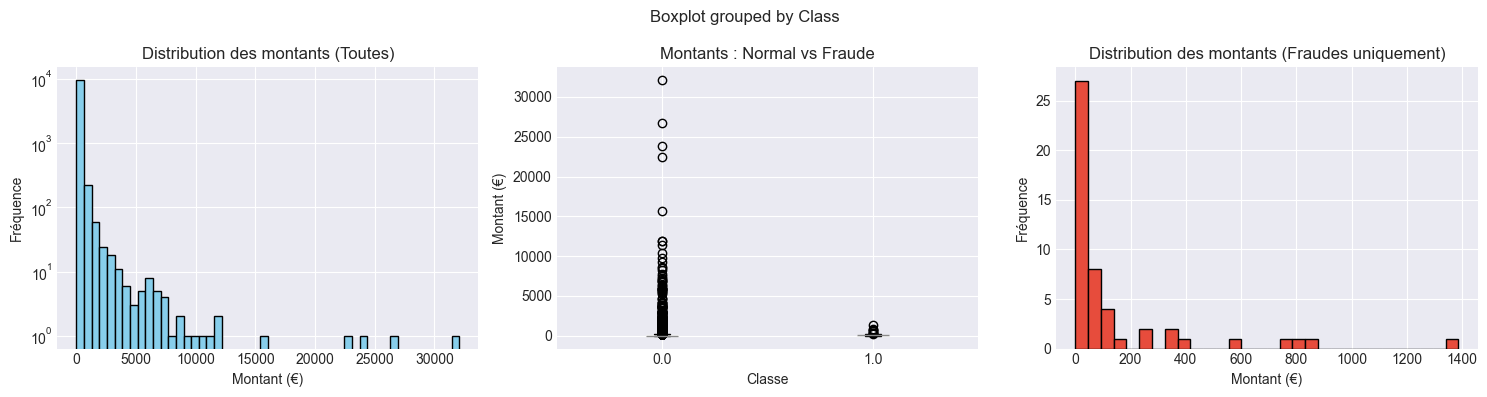

In [5]:
# Stats sur les montants
print("=== Statistiques des montants ===\n")
print("Toutes transactions:")
print(df['Amount'].describe())
print("\n" + "="*40)
print("\nTransactions normales:")
print(df[df['Class']==0]['Amount'].describe())
print("\n" + "="*40)
print("\nFraudes:")
print(df[df['Class']==1]['Amount'].describe())

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution des montants (toutes transactions)
df['Amount'].hist(bins=50, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribution des montants (Toutes)')
axes[0].set_xlabel('Montant (€)')
axes[0].set_ylabel('Fréquence')
axes[0].set_yscale('log')

# Boxplot comparaison
df.boxplot(column='Amount', by='Class', ax=axes[1])
axes[1].set_title('Montants : Normal vs Fraude')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Montant (€)')

# Distribution pour fraudes uniquement (pour mieux voir)
df[df['Class']==1]['Amount'].hist(bins=30, ax=axes[2], color='#e74c3c', edgecolor='black')
axes[2].set_title('Distribution des montants (Fraudes uniquement)')
axes[2].set_xlabel('Montant (€)')
axes[2].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

# Observation perso : Les fraudes semblent avoir des montants assez variables. 
# Pas de pattern évident juste avec Amount. Les features V1-V28 vont être importantes.
